# Fardous Sabnur


#### Importing libraries

In [1]:
from sklearn.model_selection import train_test_split
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import pandas as pd
import os

np.random.seed(8112)

#Data Visualizing libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import tensorflow as tf
from tensorflow import keras

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
### Reading the dastaset

In [3]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [4]:
print("X_train:", X_train_full.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train_full.shape)
print("y_test:", y_test.shape)

X_train: (60000, 28, 28)
X_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)


In [5]:
# now we conveert the image pixels for the X's from integer to float
X_train_full, X_test = X_train_full / 255., X_test / 255.

In [6]:
## Splitting the training data to create validation sets

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,  random_state = 8112)
X_test = X_test


In [8]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_valid:", y_valid.shape)

X_train: (45000, 28, 28)
X_test: (10000, 28, 28)
X_valid: (15000, 28, 28)
y_train: (45000,)
y_test: (10000,)
y_valid: (15000,)


### Visualizing the data

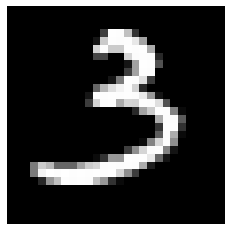

In [9]:
plt.imshow(X_valid[0], cmap="gray")
plt.axis('off')
plt.show()

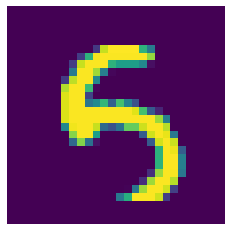

In [10]:
plt.imshow(X_valid[2])
plt.axis('off')
plt.show()

In [11]:
class_names = [["0", "1", "2", "3", "4",
               "5", "6", "7", "8", "9"]]

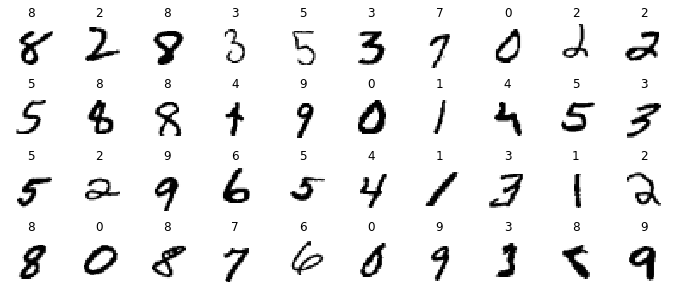

In [12]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Creating the Deep Multilayer Perceptron model

In [13]:
def build_model(n_hidden = 3, learning_rate=3e-3): 
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(200, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [14]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [15]:
keras.backend.clear_session()
np.random.seed(8112) #(42)
tf.random.set_seed(8112) #(42)

In [16]:
history = keras_reg.fit(X_train, y_train, epochs=10,
              validation_data=(X_valid, y_valid),
              )

Epoch 1/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.9964 - accuracy: 0.3989 - val_loss: 0.6924 - val_accuracy: 0.8334
Epoch 2/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.5859 - accuracy: 0.8484 - val_loss: 0.4187 - val_accuracy: 0.8861
Epoch 3/10
1407/1407 [==============================] - 2s 2ms/step - loss: 0.3929 - accuracy: 0.8892 - val_loss: 0.3502 - val_accuracy: 0.9026
Epoch 4/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3331 - accuracy: 0.9055 - val_loss: 0.3147 - val_accuracy: 0.9110
Epoch 5/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2956 - accuracy: 0.9159 - val_loss: 0.2907 - val_accuracy: 0.9169
Epoch 6/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2740 - accuracy: 0.9206 - val_loss: 0.2690 - val_accuracy: 0.9234
Epoch 7/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.2536 - accuracy: 0.9256 - val_loss: 0.2556 - val_accuracy:

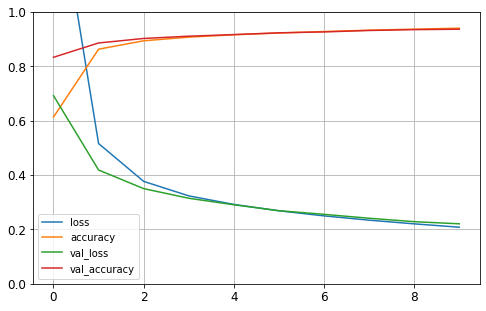

In [17]:
# Visualizing the model

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

the loss function shoots down after 1 epoch

In [18]:
model = build_model()

In [19]:
model.save("my_keras_model.h5")

In [20]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)


#### Fine tuning the model using randomized search CV

In [21]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "learning_rate": reciprocal(1e-2, 0.03, 0.3)      .rvs(1000).tolist(),
}


rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=2, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=10,
                  validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] n_hidden=1, learning_rate=0.310460541163272 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
704/704 [==============================] - 1s 2ms/step - loss: 0.5403 - accuracy: 0.8305 - val_loss: 0.1830 - val_accuracy: 0.9473
Epoch 2/10
704/704 [==============================] - 1s 1ms/step - loss: 0.1395 - accuracy: 0.9580 - val_loss: 0.1542 - val_accuracy: 0.9537
Epoch 3/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0899 - accuracy: 0.9727 - val_loss: 0.1240 - val_accuracy: 0.9645
Epoch 4/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.5523 - val_accuracy: 0.8688
Epoch 5/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0518 - accuracy: 0.9843 - val_loss: 0.1165 - val_accuracy: 0.9661
Epoch 6/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0295 - accuracy: 0.9922 - val_loss: 0.1081 - val_accuracy: 0.9702
Epoch 7/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0194 - accuracy: 0.9958 - val_loss: 0.1097 - val_accuracy: 0.9706
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


Epoch 1/10
704/704 [==============================] - 1s 1ms/step - loss: 0.5468 - accuracy: 0.8296 - val_loss: 0.2273 - val_accuracy: 0.9291
Epoch 2/10
704/704 [==============================] - 1s 1ms/step - loss: 0.1467 - accuracy: 0.9568 - val_loss: 0.1777 - val_accuracy: 0.9466
Epoch 3/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0953 - accuracy: 0.9705 - val_loss: 2.2455 - val_accuracy: 0.7795
Epoch 4/10
704/704 [==============================] - 1s 1ms/step - loss: 0.1219 - accuracy: 0.9724 - val_loss: 0.1161 - val_accuracy: 0.9671
Epoch 5/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.1106 - val_accuracy: 0.9697
Epoch 6/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0308 - accuracy: 0.9919 - val_loss: 0.1051 - val_accuracy: 0.9707
Epoch 7/10
704/704 [==============================] - 1s 1ms/step - loss: 0.0208 - accuracy: 0.9946 - val_loss: 0.1186 - val_accuracy: 0.9676
Epoch 

Epoch 1/10
704/704 [==============================] - 2s 2ms/step - loss: 0.5316 - accuracy: 0.8297 - val_loss: 0.1708 - val_accuracy: 0.9511
Epoch 2/10
704/704 [==============================] - 1s 2ms/step - loss: 0.1372 - accuracy: 0.9566 - val_loss: 0.1476 - val_accuracy: 0.9570
Epoch 3/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0860 - accuracy: 0.9735 - val_loss: 0.1208 - val_accuracy: 0.9657
Epoch 4/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0581 - accuracy: 0.9831 - val_loss: 0.2672 - val_accuracy: 0.9234
Epoch 5/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0440 - accuracy: 0.9849 - val_loss: 0.1082 - val_accuracy: 0.9683
Epoch 6/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0260 - accuracy: 0.9932 - val_loss: 0.1063 - val_accuracy: 0.9699
Epoch 7/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0174 - accuracy: 0.9961 - val_loss: 0.1065 - val_accuracy: 0.9707
Epoch 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min finished


1407/1407 [==============================] - 2s 1ms/step - loss: 0.4087 - accuracy: 0.8742 - val_loss: 0.1506 - val_accuracy: 0.9530
Epoch 2/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.1105 - accuracy: 0.9651 - val_loss: 0.1160 - val_accuracy: 0.9649
Epoch 3/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.0674 - accuracy: 0.9785 - val_loss: 0.1241 - val_accuracy: 0.9623
Epoch 4/10
1407/1407 [==============================] - 3s 2ms/step - loss: 0.0482 - accuracy: 0.9857 - val_loss: 0.0942 - val_accuracy: 0.9735
Epoch 5/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0917 - val_accuracy: 0.9745
Epoch 6/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0259 - accuracy: 0.9926 - val_loss: 0.1001 - val_accuracy: 0.9740
Epoch 7/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0894 - val_accuracy: 0.9767
Epo

RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd53ac7e790>,
                   n_iter=5,
                   param_distributions={'learning_rate': [0.3161418345150382,
                                                          0.328957905621962,
                                                          0.3120236351421131,
                                                          0.3107149553885416,
                                                          0.3232805772395975,
                                                          0.3152902650989248,
                                                          0.3227935036978783,
                                                          0.31481057716673794,
                                                          0.32138438254820806,
                                                          0.3106980030...
                                                   

In [22]:
#The parameters that work the best

rnd_search_cv.best_params_

{'n_hidden': 1, 'learning_rate': 0.3116419329308625}

In [23]:
rnd_search_cv.score(X_test, y_test)

313/313 [==============================] - 0s 654us/step - loss: 0.0725 - accuracy: 0.9803


-0.07249613851308823

In [24]:
model = rnd_search_cv.best_estimator_.model
model

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 642us/step - loss: 0.0725 - accuracy: 0.9803


[0.07249613851308823, 0.9803000092506409]


### After evaluating the model we find over 98% accuracy

#### Tensorboard visualization

In [26]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [27]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_03_10-01_28_31'

In [28]:
keras.backend.clear_session()
np.random.seed(8112)
tf.random.set_seed(8112)

In [29]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0828 - val_accuracy: 0.9807
Epoch 2/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0833 - val_accuracy: 0.9805
Epoch 3/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0842 - val_accuracy: 0.9808
Epoch 4/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0847 - val_accuracy: 0.9810
Epoch 5/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 0.9808
Epoch 6/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9817
Epoch 7/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0863 - val_accuracy:

In [30]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006